<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [16]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [19]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [20]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [21]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10),
            nn.ReLU(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [22]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [23]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [24]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 10

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [25]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [26]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.6826, Loss:  0.0043
Epoch	2	Acc:  0.8747, Loss:  0.0018
Epoch	3	Acc:  0.8953, Loss:  0.0015
Epoch	4	Acc:  0.9050, Loss:  0.0013
Epoch	5	Acc:  0.9114, Loss:  0.0012
Epoch	6	Acc:  0.9151, Loss:  0.0012
Epoch	7	Acc:  0.9170, Loss:  0.0011
Epoch	8	Acc:  0.9200, Loss:  0.0011
Epoch	9	Acc:  0.9214, Loss:  0.0011
Epoch	10	Acc:  0.9229, Loss:  0.0011
Task 0 Acc:  0.9246, Loss:  0.0011
Task 1 Acc:  0.1296, Loss:  0.0262

Task 1 Start!
Epoch	1	Acc:  0.2977, Loss:  0.0129
Epoch	2	Acc:  0.5460, Loss:  0.0076
Epoch	3	Acc:  0.6300, Loss:  0.0067
Epoch	4	Acc:  0.6635, Loss:  0.0063
Epoch	5	Acc:  0.6794, Loss:  0.0061
Epoch	6	Acc:  0.6894, Loss:  0.0060
Epoch	7	Acc:  0.6955, Loss:  0.0059
Epoch	8	Acc:  0.6995, Loss:  0.0058
Epoch	9	Acc:  0.7024, Loss:  0.0058
Epoch	10	Acc:  0.7041, Loss:  0.0058
Task 0 Acc:  0.6929, Loss:  0.0043
Task 1 Acc:  0.7075, Loss:  0.0039



 - Task 0

Accuracy 0.6929
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.89      0.87      0.88       980
     1 - one       0.74      0.98      0.84      1135
     2 - two       0.59      0.72      0.65      1032
   3 - three       0.77      0.72      0.74      1010
    4 - four       0.41      0.77      0.53       982
    5 - five       0.62      0.27      0.38       892
     6 - six       0.76      0.85      0.80       958
   7 - seven       0.93      0.71      0.81      1028
   8 - eight       0.74      0.40      0.52       974
    9 - nine       0.78      0.54      0.64      1009

    accuracy                           0.69     10000
   macro avg       0.72      0.68      0.68     10000
weighted avg       0.72      0.69      0.69     10000



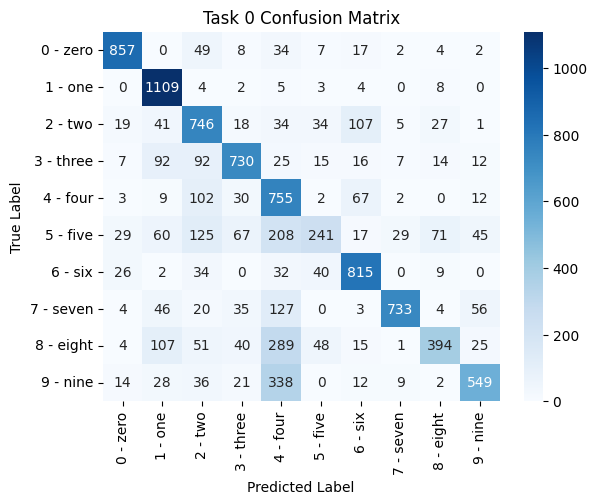

In [27]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.7075
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.77      0.90      0.83       980
     1 - one       0.81      0.87      0.84      1135
     2 - two       0.72      0.57      0.64      1032
   3 - three       0.64      0.45      0.52      1010
    4 - four       0.68      0.73      0.70       982
    5 - five       0.59      0.56      0.58       892
     6 - six       0.84      0.83      0.84       958
   7 - seven       0.76      0.80      0.78      1028
   8 - eight       0.52      0.68      0.59       974
    9 - nine       0.73      0.67      0.70      1009

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



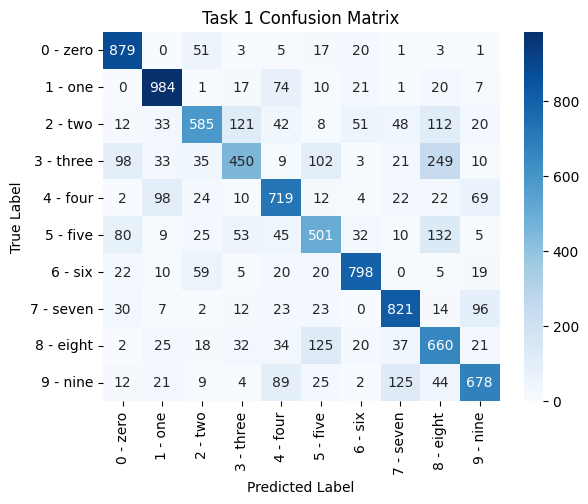

In [28]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.06473 and it's parameter diff is 0.00287
Min Parameter diff is 0.96033 and it's fisher is 0.00000
fisher > parameter diff: 91
fisher <= parameter diff: 693


<Figure size 640x480 with 0 Axes>

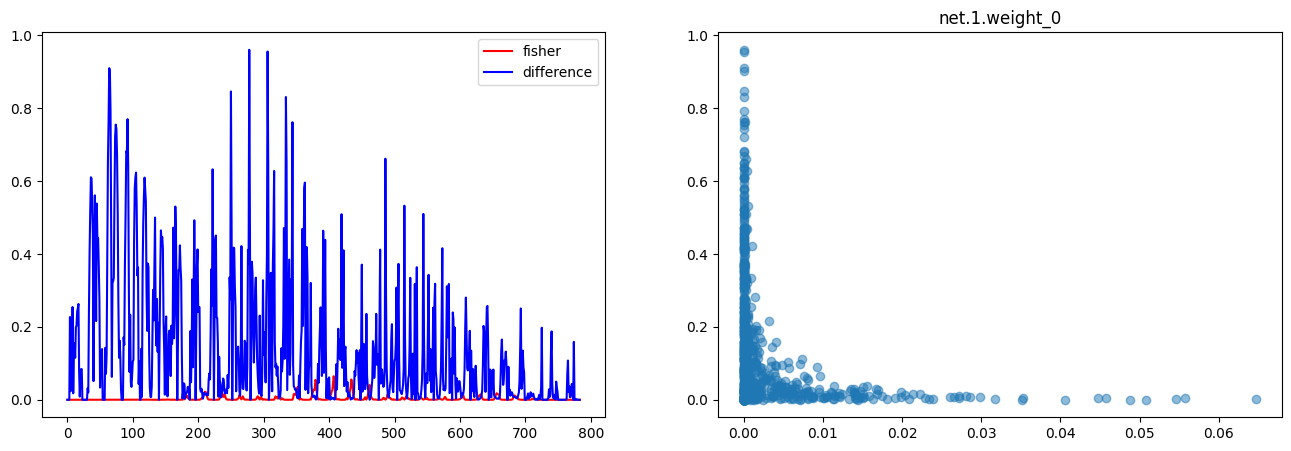

Max fisher is 0.02542 and it's parameter diff is 0.00104
Min Parameter diff is 0.98328 and it's fisher is 0.00001
fisher > parameter diff: 87
fisher <= parameter diff: 697


<Figure size 640x480 with 0 Axes>

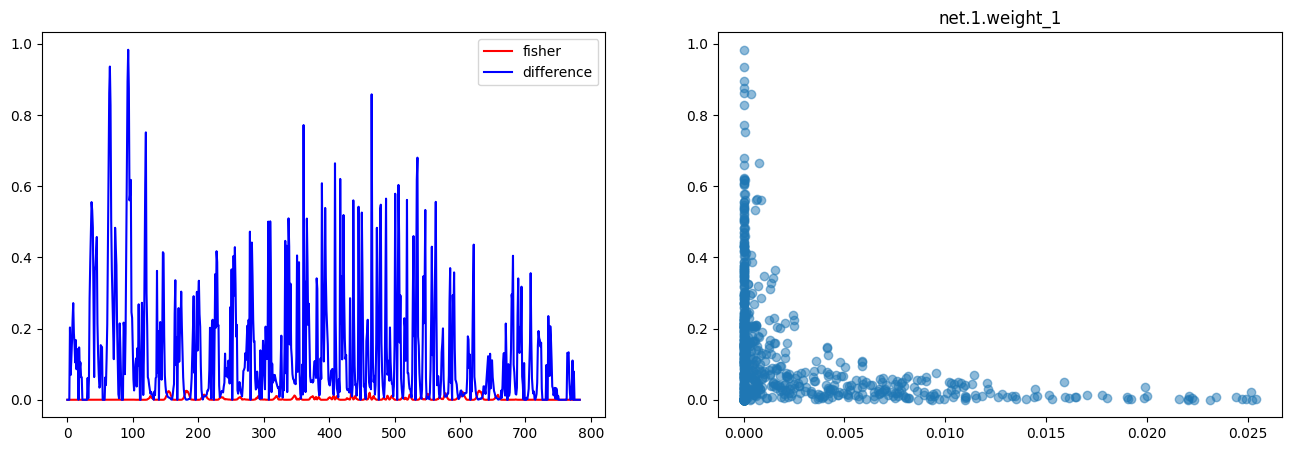

Max fisher is 0.14885 and it's parameter diff is 0.00138
Min Parameter diff is 1.19236 and it's fisher is 0.00002
fisher > parameter diff: 240
fisher <= parameter diff: 544


<Figure size 640x480 with 0 Axes>

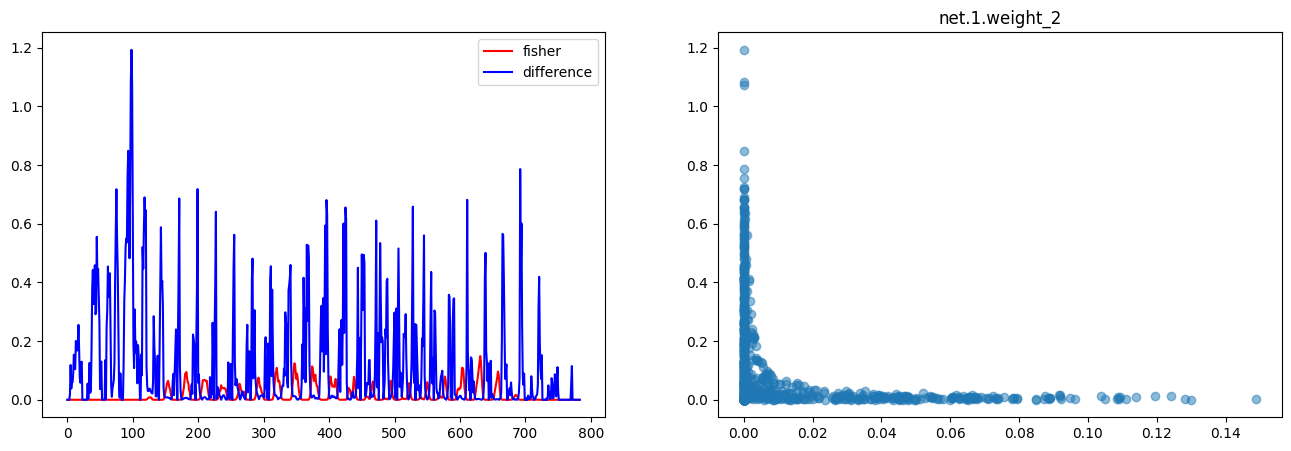

Max fisher is 0.01125 and it's parameter diff is 0.00612
Min Parameter diff is 0.70789 and it's fisher is 0.00001
fisher > parameter diff: 41
fisher <= parameter diff: 743


<Figure size 640x480 with 0 Axes>

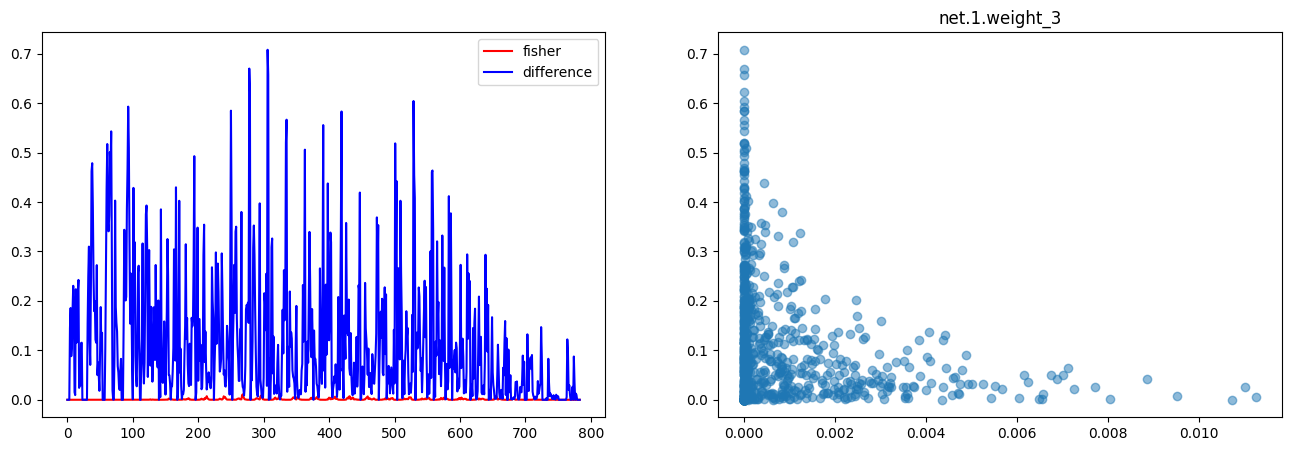

Max fisher is 0.01105 and it's parameter diff is 0.02714
Min Parameter diff is 0.89324 and it's fisher is 0.00000
fisher > parameter diff: 29
fisher <= parameter diff: 755


<Figure size 640x480 with 0 Axes>

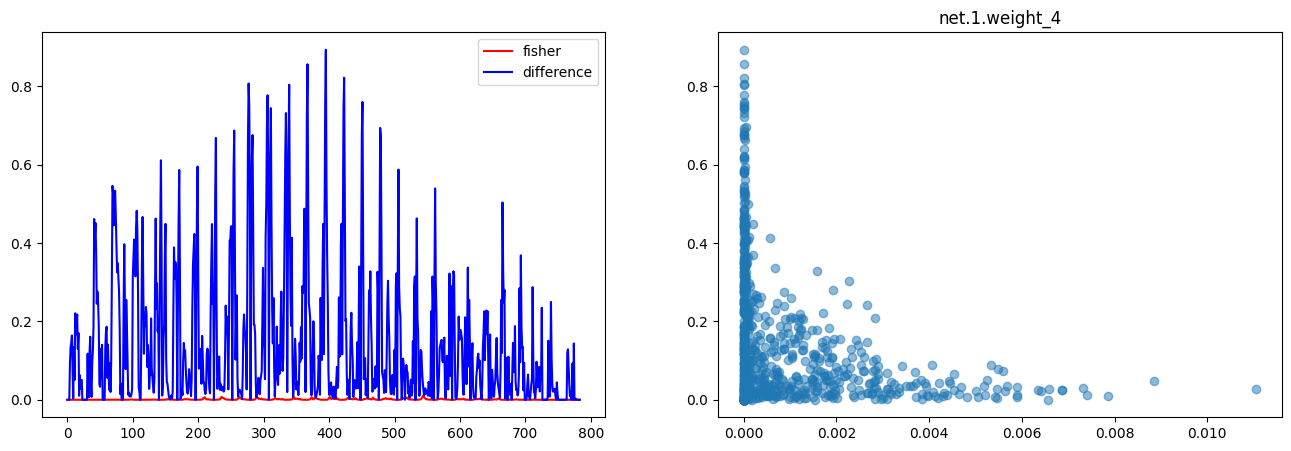

Max fisher is 0.00000 and it's parameter diff is 0.00000
Min Parameter diff is 0.00000 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 784


<Figure size 640x480 with 0 Axes>

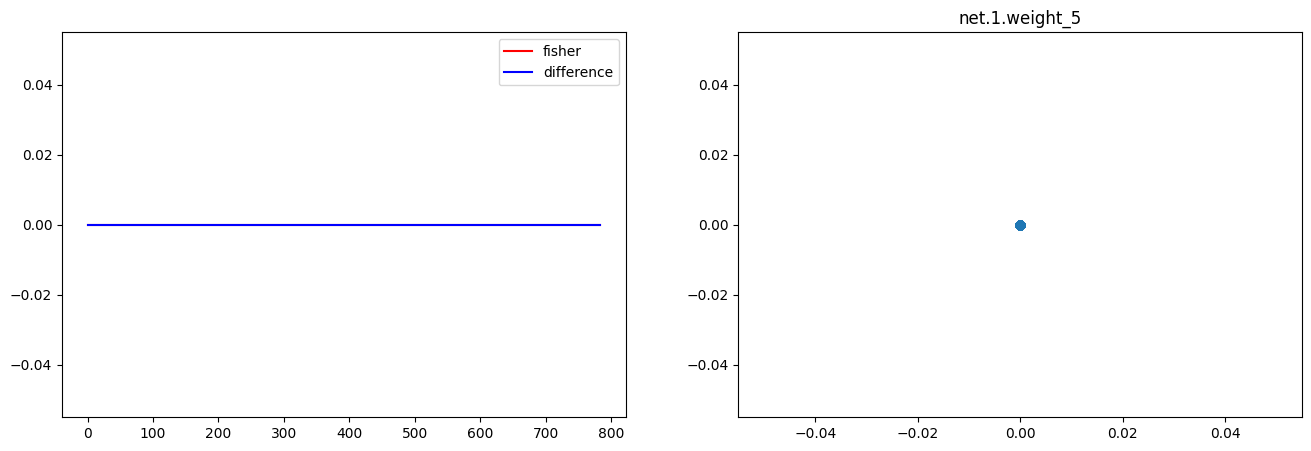

Max fisher is 0.07225 and it's parameter diff is 0.00103
Min Parameter diff is 1.04847 and it's fisher is 0.00000
fisher > parameter diff: 151
fisher <= parameter diff: 633


<Figure size 640x480 with 0 Axes>

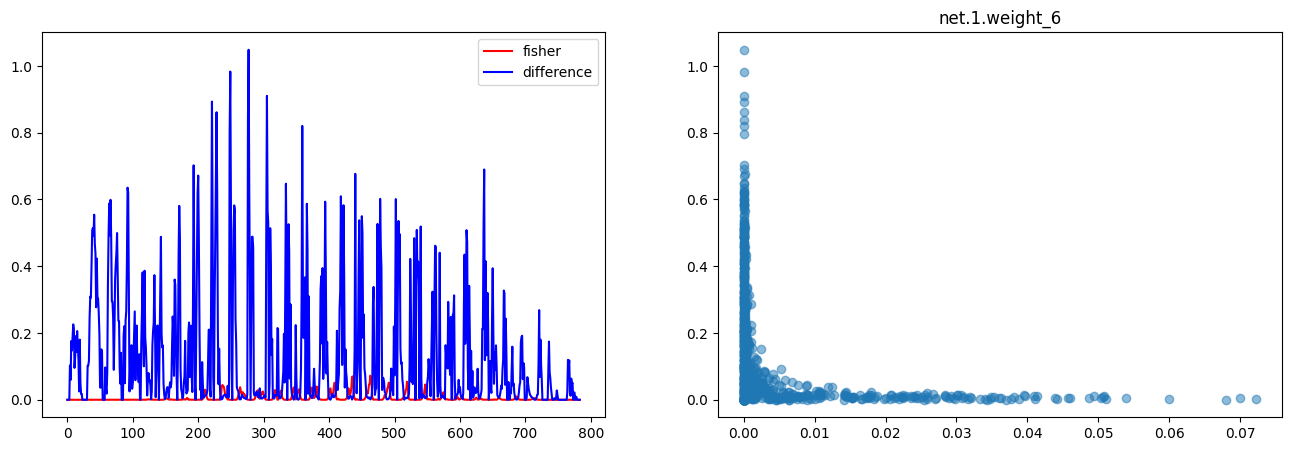

Max fisher is 0.33499 and it's parameter diff is 0.00423
Min Parameter diff is 1.10421 and it's fisher is 0.00000
fisher > parameter diff: 313
fisher <= parameter diff: 471


<Figure size 640x480 with 0 Axes>

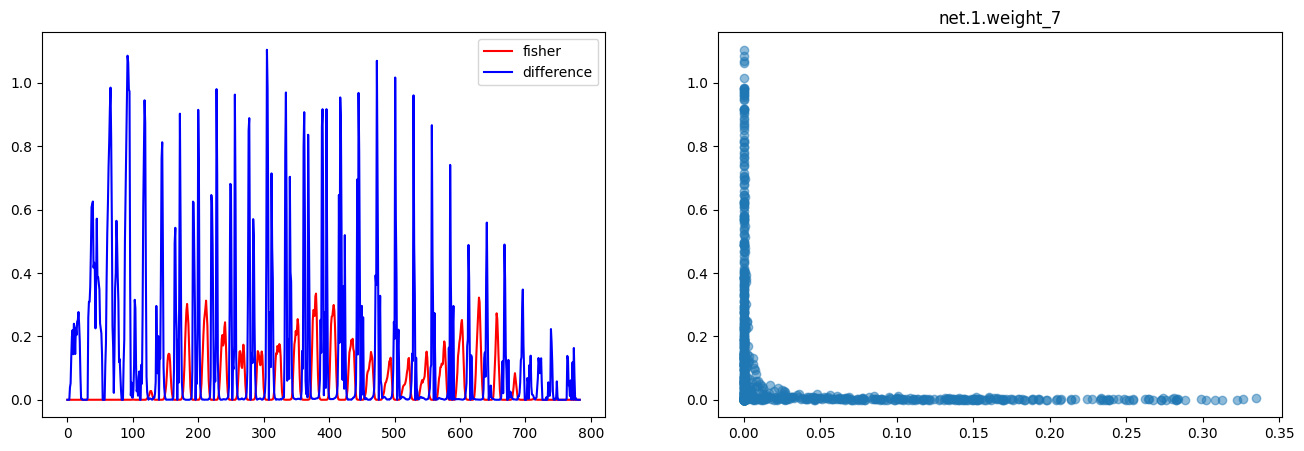

Max fisher is 0.13653 and it's parameter diff is 0.00184
Min Parameter diff is 0.84777 and it's fisher is 0.00006
fisher > parameter diff: 289
fisher <= parameter diff: 495


<Figure size 640x480 with 0 Axes>

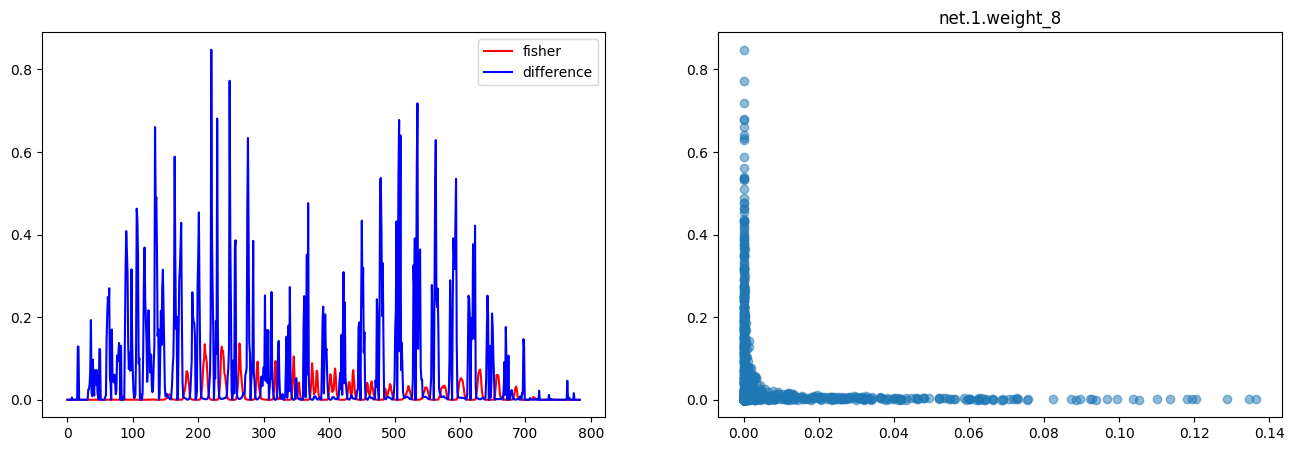

Max fisher is 0.33661 and it's parameter diff is 0.00000
Min Parameter diff is 0.86427 and it's fisher is 0.00001
fisher > parameter diff: 342
fisher <= parameter diff: 442


<Figure size 640x480 with 0 Axes>

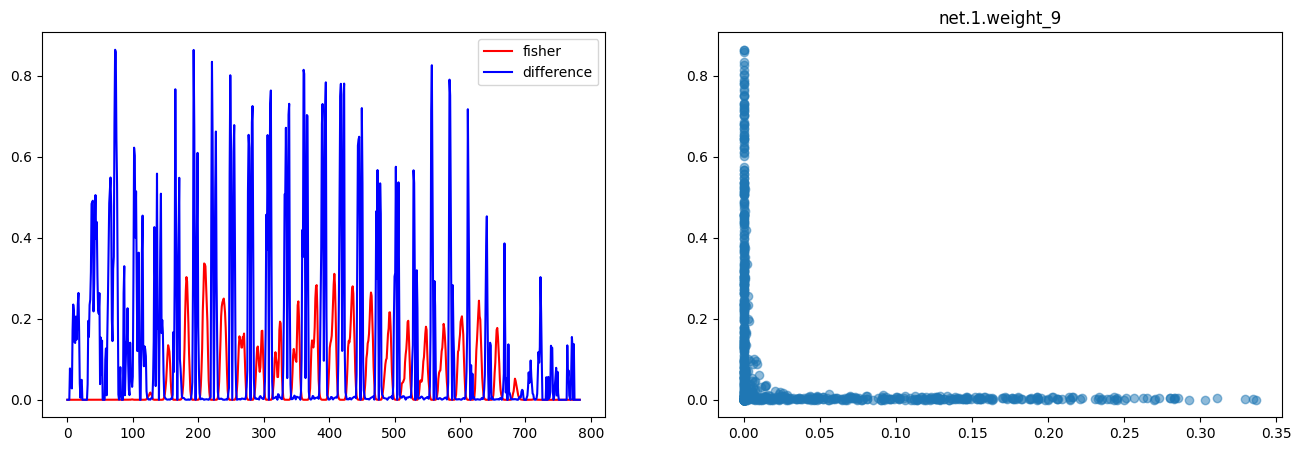


net.1.bias
torch.Size([10])
Max fisher is 0.79329 and it's parameter diff is 0.00064
Min Parameter diff is 0.02405 and it's fisher is 0.00701
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

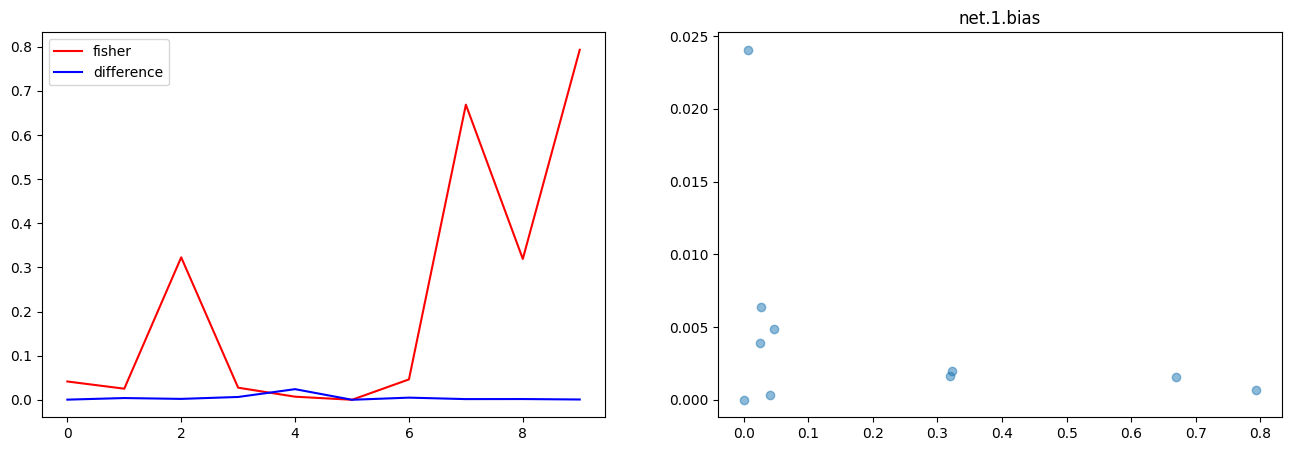


net.3.weight
torch.Size([10, 10])
Max fisher is 15.19227 and it's parameter diff is 0.00011
Min Parameter diff is 0.00142 and it's fisher is 4.07039
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

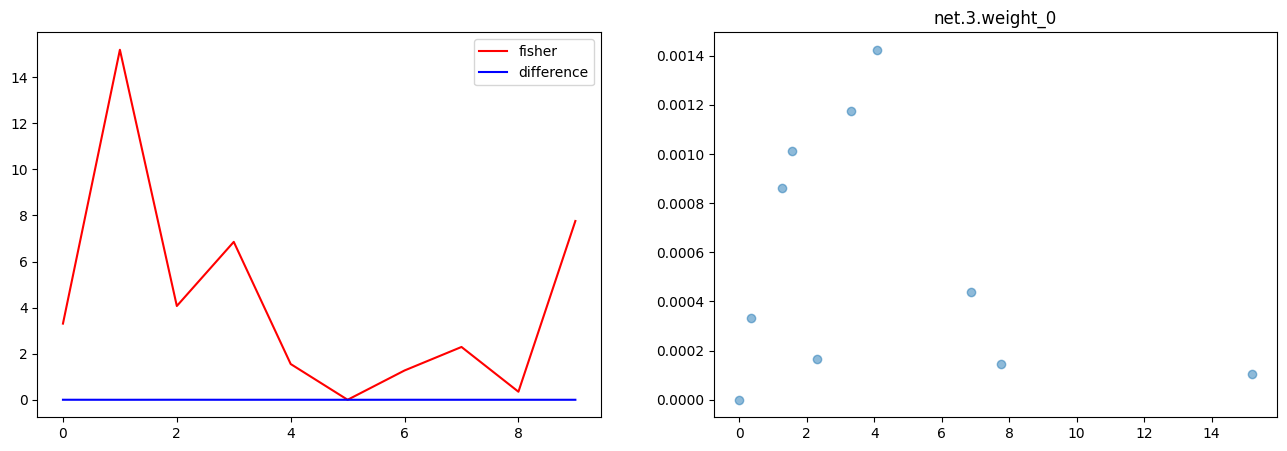

Max fisher is 0.13460 and it's parameter diff is 0.00577
Min Parameter diff is 0.21767 and it's fisher is 0.01068
fisher > parameter diff: 4
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

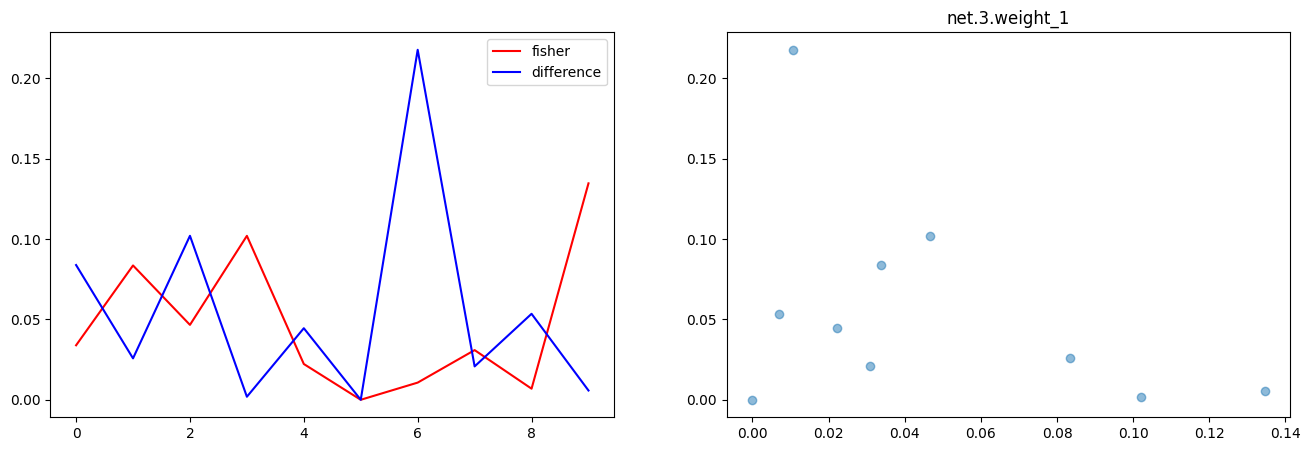

Max fisher is 7.78971 and it's parameter diff is 0.00120
Min Parameter diff is 0.00399 and it's fisher is 0.37011
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

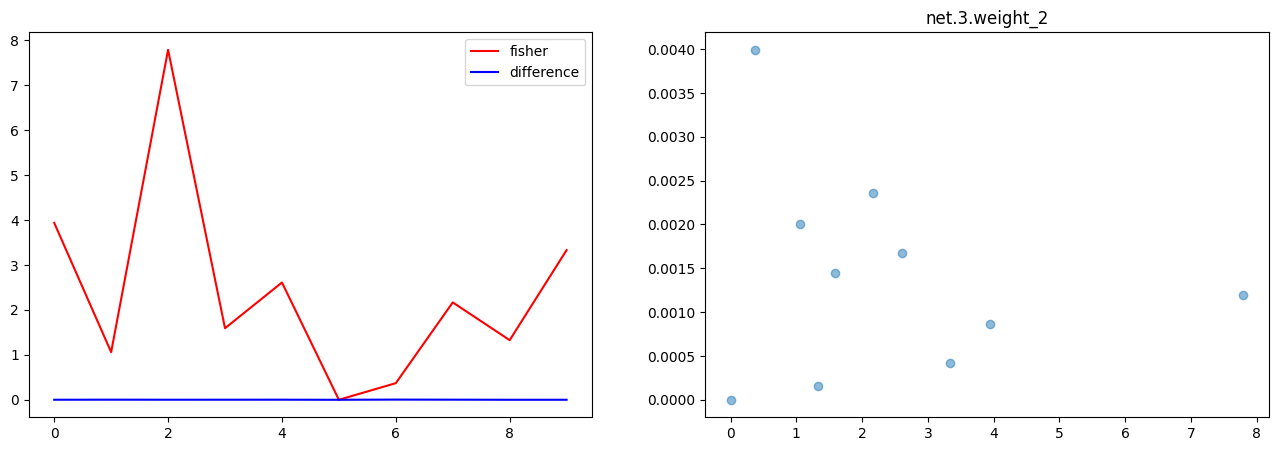

Max fisher is 52.37033 and it's parameter diff is 0.00002
Min Parameter diff is 0.00038 and it's fisher is 49.50620
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

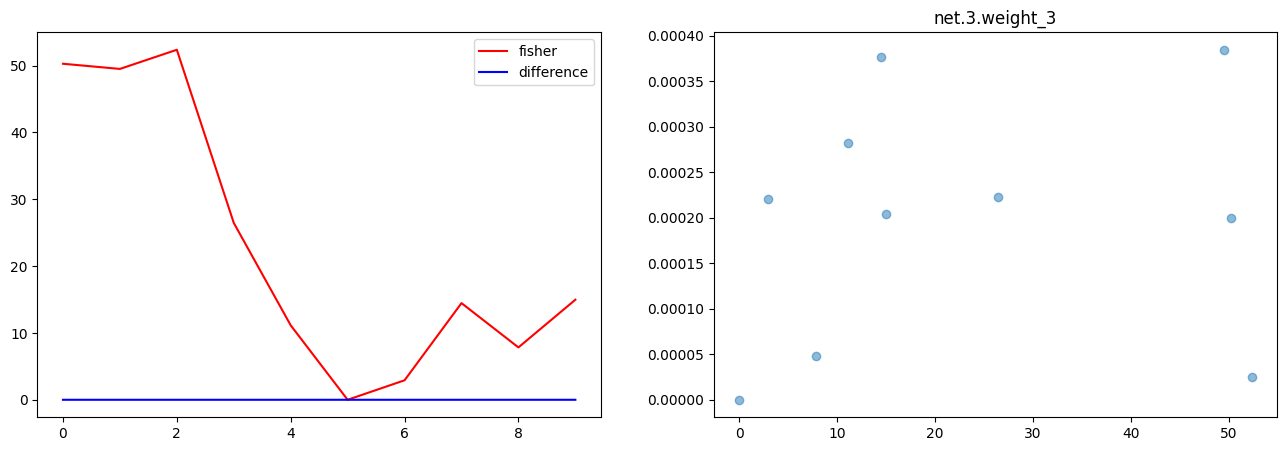

Max fisher is 3.55192 and it's parameter diff is 0.00077
Min Parameter diff is 0.04413 and it's fisher is 0.01776
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

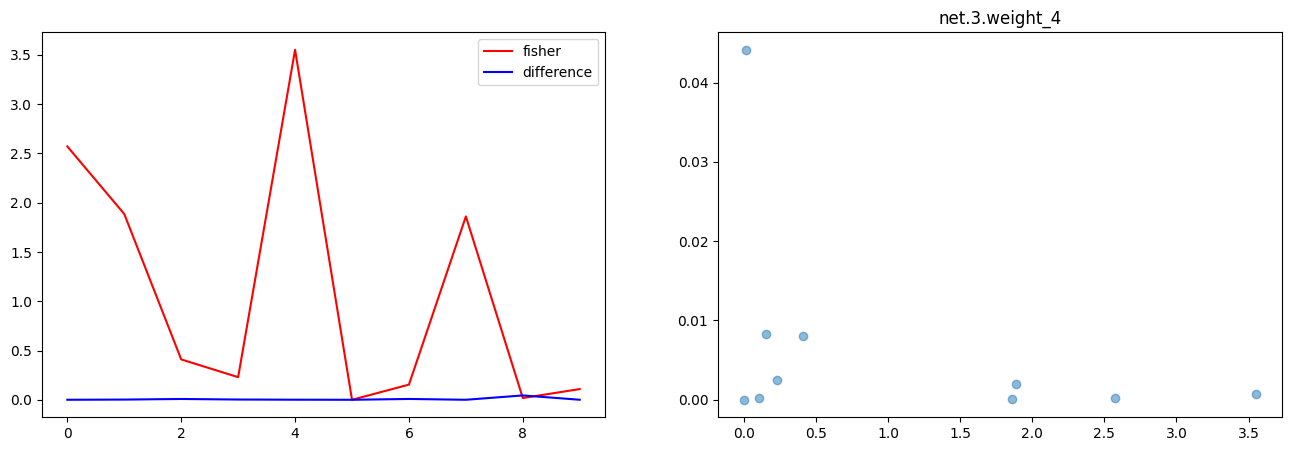

Max fisher is 42.26683 and it's parameter diff is 0.00001
Min Parameter diff is 0.00103 and it's fisher is 2.99114
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

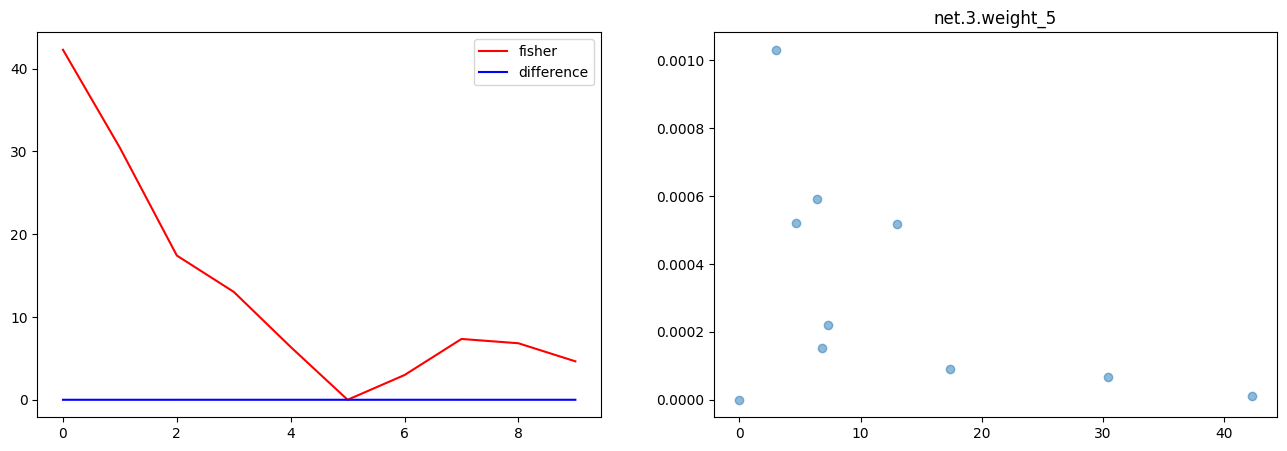

Max fisher is 0.61189 and it's parameter diff is 0.00048
Min Parameter diff is 0.11944 and it's fisher is 0.02345
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

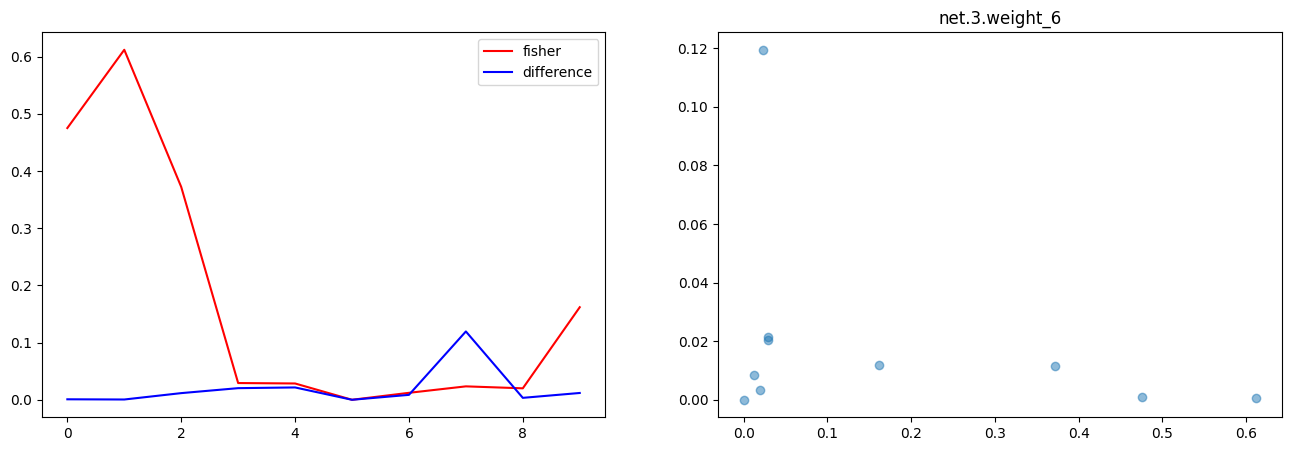

Max fisher is 0.64577 and it's parameter diff is 0.00396
Min Parameter diff is 0.06651 and it's fisher is 0.02737
fisher > parameter diff: 7
fisher <= parameter diff: 3


<Figure size 640x480 with 0 Axes>

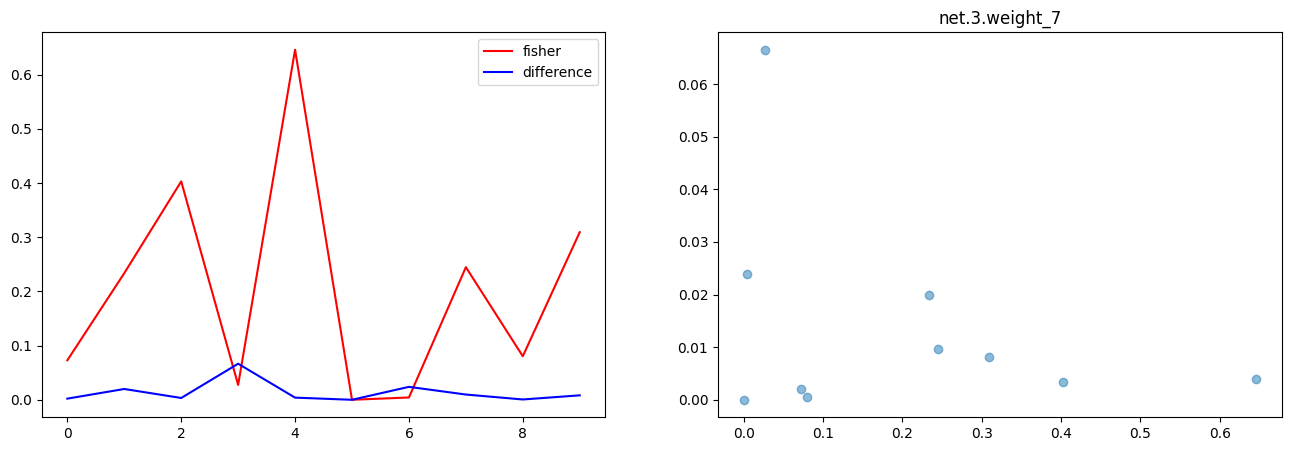

Max fisher is 7.55999 and it's parameter diff is 0.00081
Min Parameter diff is 0.00612 and it's fisher is 0.92165
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

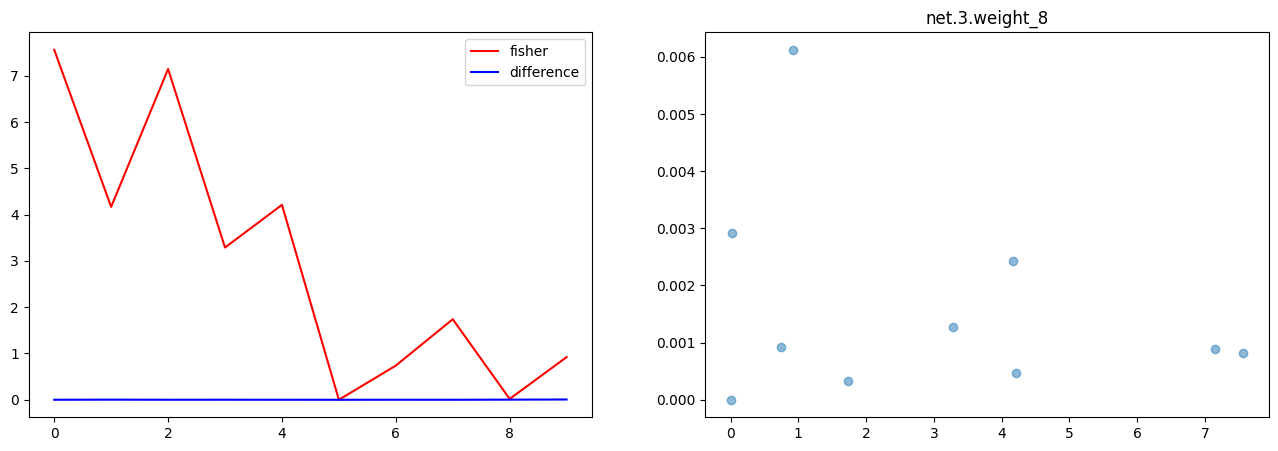

Max fisher is 46.61101 and it's parameter diff is 0.00006
Min Parameter diff is 0.00075 and it's fisher is 7.10221
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

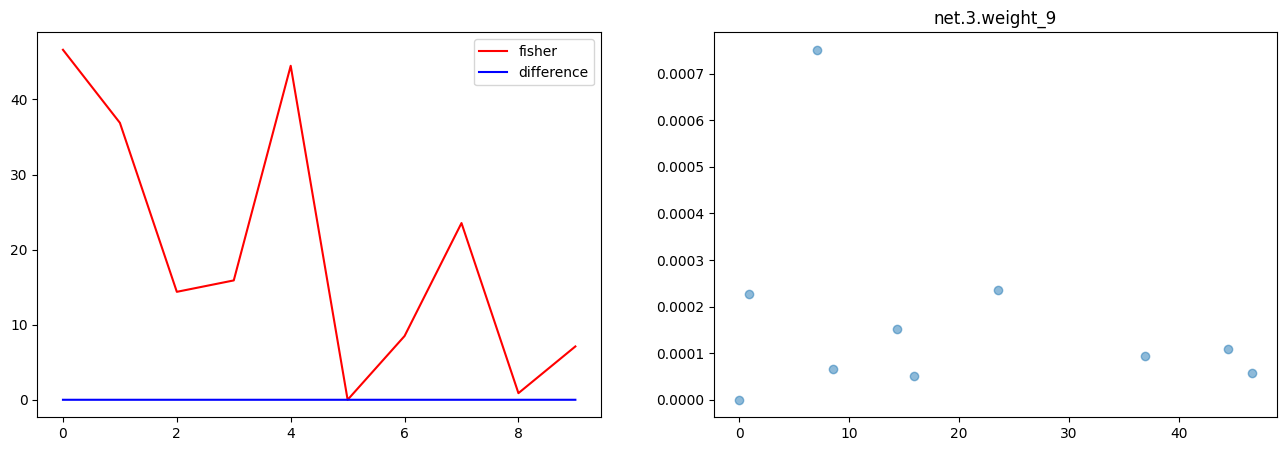


net.3.bias
torch.Size([10])
Max fisher is 0.57177 and it's parameter diff is 0.00334
Min Parameter diff is 0.29471 and it's fisher is 0.00491
fisher > parameter diff: 5
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

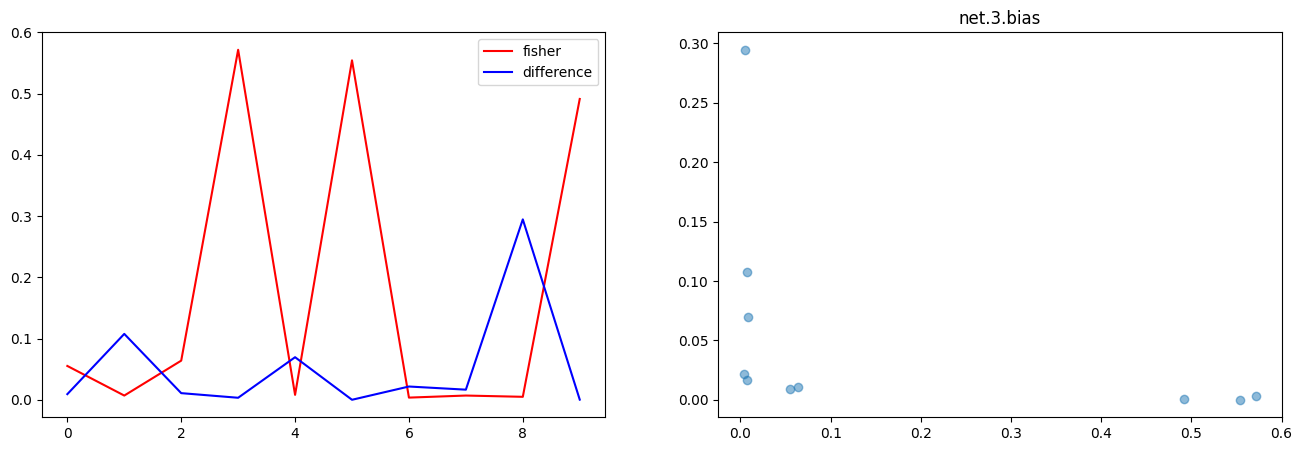

In [29]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [30]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_13_36_30
